# Figure 2
This makes a plot with two side-by-side axes displaying the location of filter sample legs. The left plot displays the locations of the filter runs and their types. The right-hand plot shows the relative concentrations of INP across the filter legs. 

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
import os
from glob import glob

In [2]:
def convert_time_to_spm(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [3]:
# Read in relevant metadata and INP concentrations.
filter_info = pd.read_csv('/home/users/erinraif/acao_data/metadata/timings_of_filter_legs_acao.csv', index_col='unique_ID')
# Drop filter runs negated (c276r3 due to issues during experiment, c278r3 due to short run length)
filter_info = filter_info.drop(['c276r3t','c278r3t'])
INP_concentrations = pd.read_csv('/home/users/erinraif/acao_data/inp_data/INP_concentrations.csv', index_col='temp_bin')

In [4]:
filter_info['start_time_spm'] = filter_info['start_time'].apply(convert_time_to_spm)
filter_info['end_time_spm'] = filter_info['end_time'].apply(convert_time_to_spm)

In [5]:
# Read relative locations of annotations on plot (manually determined, unfortunately)
label_locs = pd.read_csv('filter_annotations.csv',index_col='unique_ID')

In [6]:
filter_info = pd.merge(filter_info, label_locs, left_index=True, right_index=True)

In [7]:
def get_filter_extents(row):
    # For each row of filter metadata, collect latitude and longitude data
    flight_data = xr.open_dataset(
                    glob('/badc/faam/data/2022/'+
                         row.flight+'*/core_processed/core_faam*'
                         +row.flight+'.nc')[-1],
                    decode_times=False,engine='netcdf4')

    time_slice = flight_data.sel(Time=slice(row.start_time_spm, row.end_time_spm))
    lat = time_slice['LAT_GIN'][:,0]
    lon = time_slice['LON_GIN'][:,0]
    row['mean_lat'] = lat.mean().values
    row['mean_lon'] = lon.mean().values
    row['east'] = lon.max().values
    row['west'] = lon.min().values
    row['north'] = lat.max().values
    row['south'] = lat.min().values
    return row


In [8]:
filter_info = filter_info.apply(lambda row: get_filter_extents(row), axis=1)

In [9]:
# Create map projection objects
NPS = ccrs.NorthPolarStereo(central_longitude=15)
PC = ccrs.PlateCarree()

In [10]:
def make_map(ax, PC, NPS, add=True):
    # Create background of maps on subplot
    ax.set_extent([0,30,67,82],crs=PC)
    # Set gridlines and axes
    gl = ax.gridlines(crs=PC, zorder=6, draw_labels=True, x_inline = False,
                      y_inline = False, linewidth=0.5, linestyle=(0, (5, 1)))
    gl.n_steps = 60
    gl.ylocator = mticker.FixedLocator(np.arange(60, 90, 2))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-20, 61, 5))
    gl.xformatter = LONGITUDE_FORMATTER
    
    gl.ylabel_style = {'fontsize': 14, 'zorder': 30, 'rotation':0, 'color': 'k'}
    gl.xlabel_style = {'fontsize': 14, 'zorder': 30, 'rotation':0, 'color': 'k'}
    gl.top_labels = False
    gl.right_labels = False
    
    # Paths to the sea-ice shapefiles for the maximum and minimum sea-ice extent
    max_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220311_c271/masie_ice_r00_v01_2022070_1km.shp'
    min_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220330_c281_c282/masie_ice_r00_v01_2022089_1km.shp'
    
    # Define coastlines, oceans and land shapes
    coasts_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', 
                                              edgecolor='black',
                                              facecolor= 'none')
    
    ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                            edgecolor='face',
                                            facecolor='lightblue')
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='lightgray')
    
    # Create sea-ice features
    max_ice = cfeature.ShapelyFeature(Reader(max_ice_path).geometries(),
                                             ccrs.NorthPolarStereo(central_longitude = -80, 
                                             true_scale_latitude = 60), facecolor = 'azure',
                                             edgecolors = 'red', linestyle='--')
    
    min_ice = cfeature.ShapelyFeature(Reader(min_ice_path).geometries(),
                                             ccrs.NorthPolarStereo(central_longitude = -80, 
                                             true_scale_latitude = 60), facecolor = 'azure',
                                             edgecolors = 'red')
    
    # add all to the map
    if add:
        ax.add_feature(ocean_50m, zorder = 1, alpha = 0.4)
        ax.add_feature(max_ice, zorder = 3, linewidth = 0.5)
        ax.add_feature(min_ice, zorder = 2, linewidth = 0.5)
        ax.add_feature(land_50m, zorder = 4, alpha = 0.4)
        ax.add_feature(coasts_50m, zorder = 5, linewidth = 0.5)
    return fig, ax

In [28]:
def plot_filter_legs(ax1, ax2, row, conc_df, cm, norm):
    # For each row of metadata, plot associated filter track
    flight_data = xr.open_dataset(
                    glob('/badc/faam/data/2022/'+
                         row.flight+'*/core_processed/core_faam*'
                         +row.flight+'.nc')[-1],
                    decode_times=False,engine='netcdf4')
    time_slice = flight_data.sel(Time=slice(row.start_time_spm, row.end_time_spm))
    lat = time_slice['LAT_GIN'][:,0]
    lon = time_slice['LON_GIN'][:,0]
    # Choose colour for ax1 plot based on run type
    if row.layer == 'above':
        c = 'deeppink'
    elif row.layer == 'below':
        c = 'darkgreen'
    elif row.layer == 'upstream':
        c = 'maroon'
    else:
        c = 'black'
    if row.name == 'c272r6t':
        # override for WAI
        c = 'black'
    
    ax1.plot(lon, lat, color=c, linewidth=2.5, transform = ccrs.PlateCarree(),zorder=6)
    # Get the INP concentration at T = -15
    N_at_15 = conc_df.loc[-15,row.name+'_NT']
    # Choose colour for plot based on this value and plot on ax2
    c = cm(norm(N_at_15))
    ax2.plot(lon, lat, color=c, linewidth=2.5,transform = ccrs.PlateCarree(),zorder=6)
    
    return row

In [26]:
def add_annotation(row, ax, color=True):
    # Choose colour for text if wanted (for ax1 case)
    if color:
        if row.layer == 'above':
            c = 'deeppink'
        elif row.layer == 'below':
            c = 'darkgreen'
        elif row.layer == 'upstream':
            c = 'maroon'
        else:
            c = 'black'
    else:
        c = 'black'
    if row.name == 'c272r6t':
        # override for WAI
        c = 'black'
    
    extent = ax.get_extent()

    # Calculate co-ordinates of label top-left corner in NPS
    label_NPS_x = extent[0] + (extent[1] - extent[0]) * row.x_extent
    label_NPS_y = extent[3] + (extent[2]-extent[3]) * row.y_extent
    label_lon, label_lat = PC.transform_point(label_NPS_x, label_NPS_y, NPS)
    t = ax.text(label_lon, label_lat, row.name[:-1],
                 transform=ccrs.PlateCarree(),
                 horizontalalignment='left',
                 verticalalignment='center_baseline',
                 color = c,
                 fontsize = 14.5,
                 zorder=7
                )
    # Get the bounding box of the text object in display coordinates
    bbox = t.get_window_extent()
    # Get start
    if row.y_extent < 0.89:
        # Find the left and right-most extent (x-coordinate) of the bounding box in pt
        left_extent_pt = bbox.x0
        right_extent_pt = bbox.x1
        # Get bounding box height midpoint in pt
        box_height_mp_pt = (bbox.y0+bbox.y1)/2
        # Convert to NPS x,y
        left_extent_NPS = ax.transData.inverted().transform((left_extent_pt, 0))[0]
        right_extent_NPS = ax.transData.inverted().transform((right_extent_pt, 0))[0]
        box_height_mp_NPS = ax.transData.inverted().transform((0, box_height_mp_pt))[1]
        if row.x_extent < 0.5: # LHS
             arrow_start_NPS = (right_extent_NPS, box_height_mp_NPS)
        else: # RHS
            arrow_start_NPS = (left_extent_NPS, box_height_mp_NPS)
    else:  # bottom row
        # Find the top of the bounding box
        top_extent_pt = bbox.y1
        # Get bounding box width midpoint in pt
        box_width_mp_pt = (bbox.x0+bbox.x1)/2
        # Convert to NPS x,y
        top_extent_NPS = ax.transData.inverted().transform((0, top_extent_pt))[1]
        box_width_mp_NPS = ax.transData.inverted().transform((box_width_mp_pt,0))[0]
        arrow_start_NPS = (box_width_mp_NPS, top_extent_NPS)

    # Check where endpoint of arrow should be and retrieve from metadata
    if row.end[0] == 'N':
        arrow_end_lat = row.north
    elif row.end[0] == 'S':
        arrow_end_lat = row.south
    elif row.end[0] == 'M':
        arrow_end_lat = row.mean_lat
    if row.end[1] == 'E':
        arrow_end_lon = row.east
    elif row.end[1] == 'W':
        arrow_end_lon = row.west
    elif row.end[1] == 'M':
        arrow_end_lon = row.mean_lon

    # Plot arrow
    arrow_end_NPS = NPS.transform_point(arrow_end_lon, arrow_end_lat, PC)
    arrow = ax.annotate("", xy=arrow_end_NPS, xytext=arrow_start_NPS,
                        arrowprops=dict(arrowstyle='->', linewidth=1,color='gray'), transform=NPS,
                       zorder=1000)
    
    return

In [13]:
def interpolate_colors(colormap, levels, value):
    # Normalize a value to [0, 1] based on the levels
    normalized_value = (value - levels[0]) / (levels[-1] - levels[0])
    # Map the normalized value to the colormap
    return colormap(normalized_value)


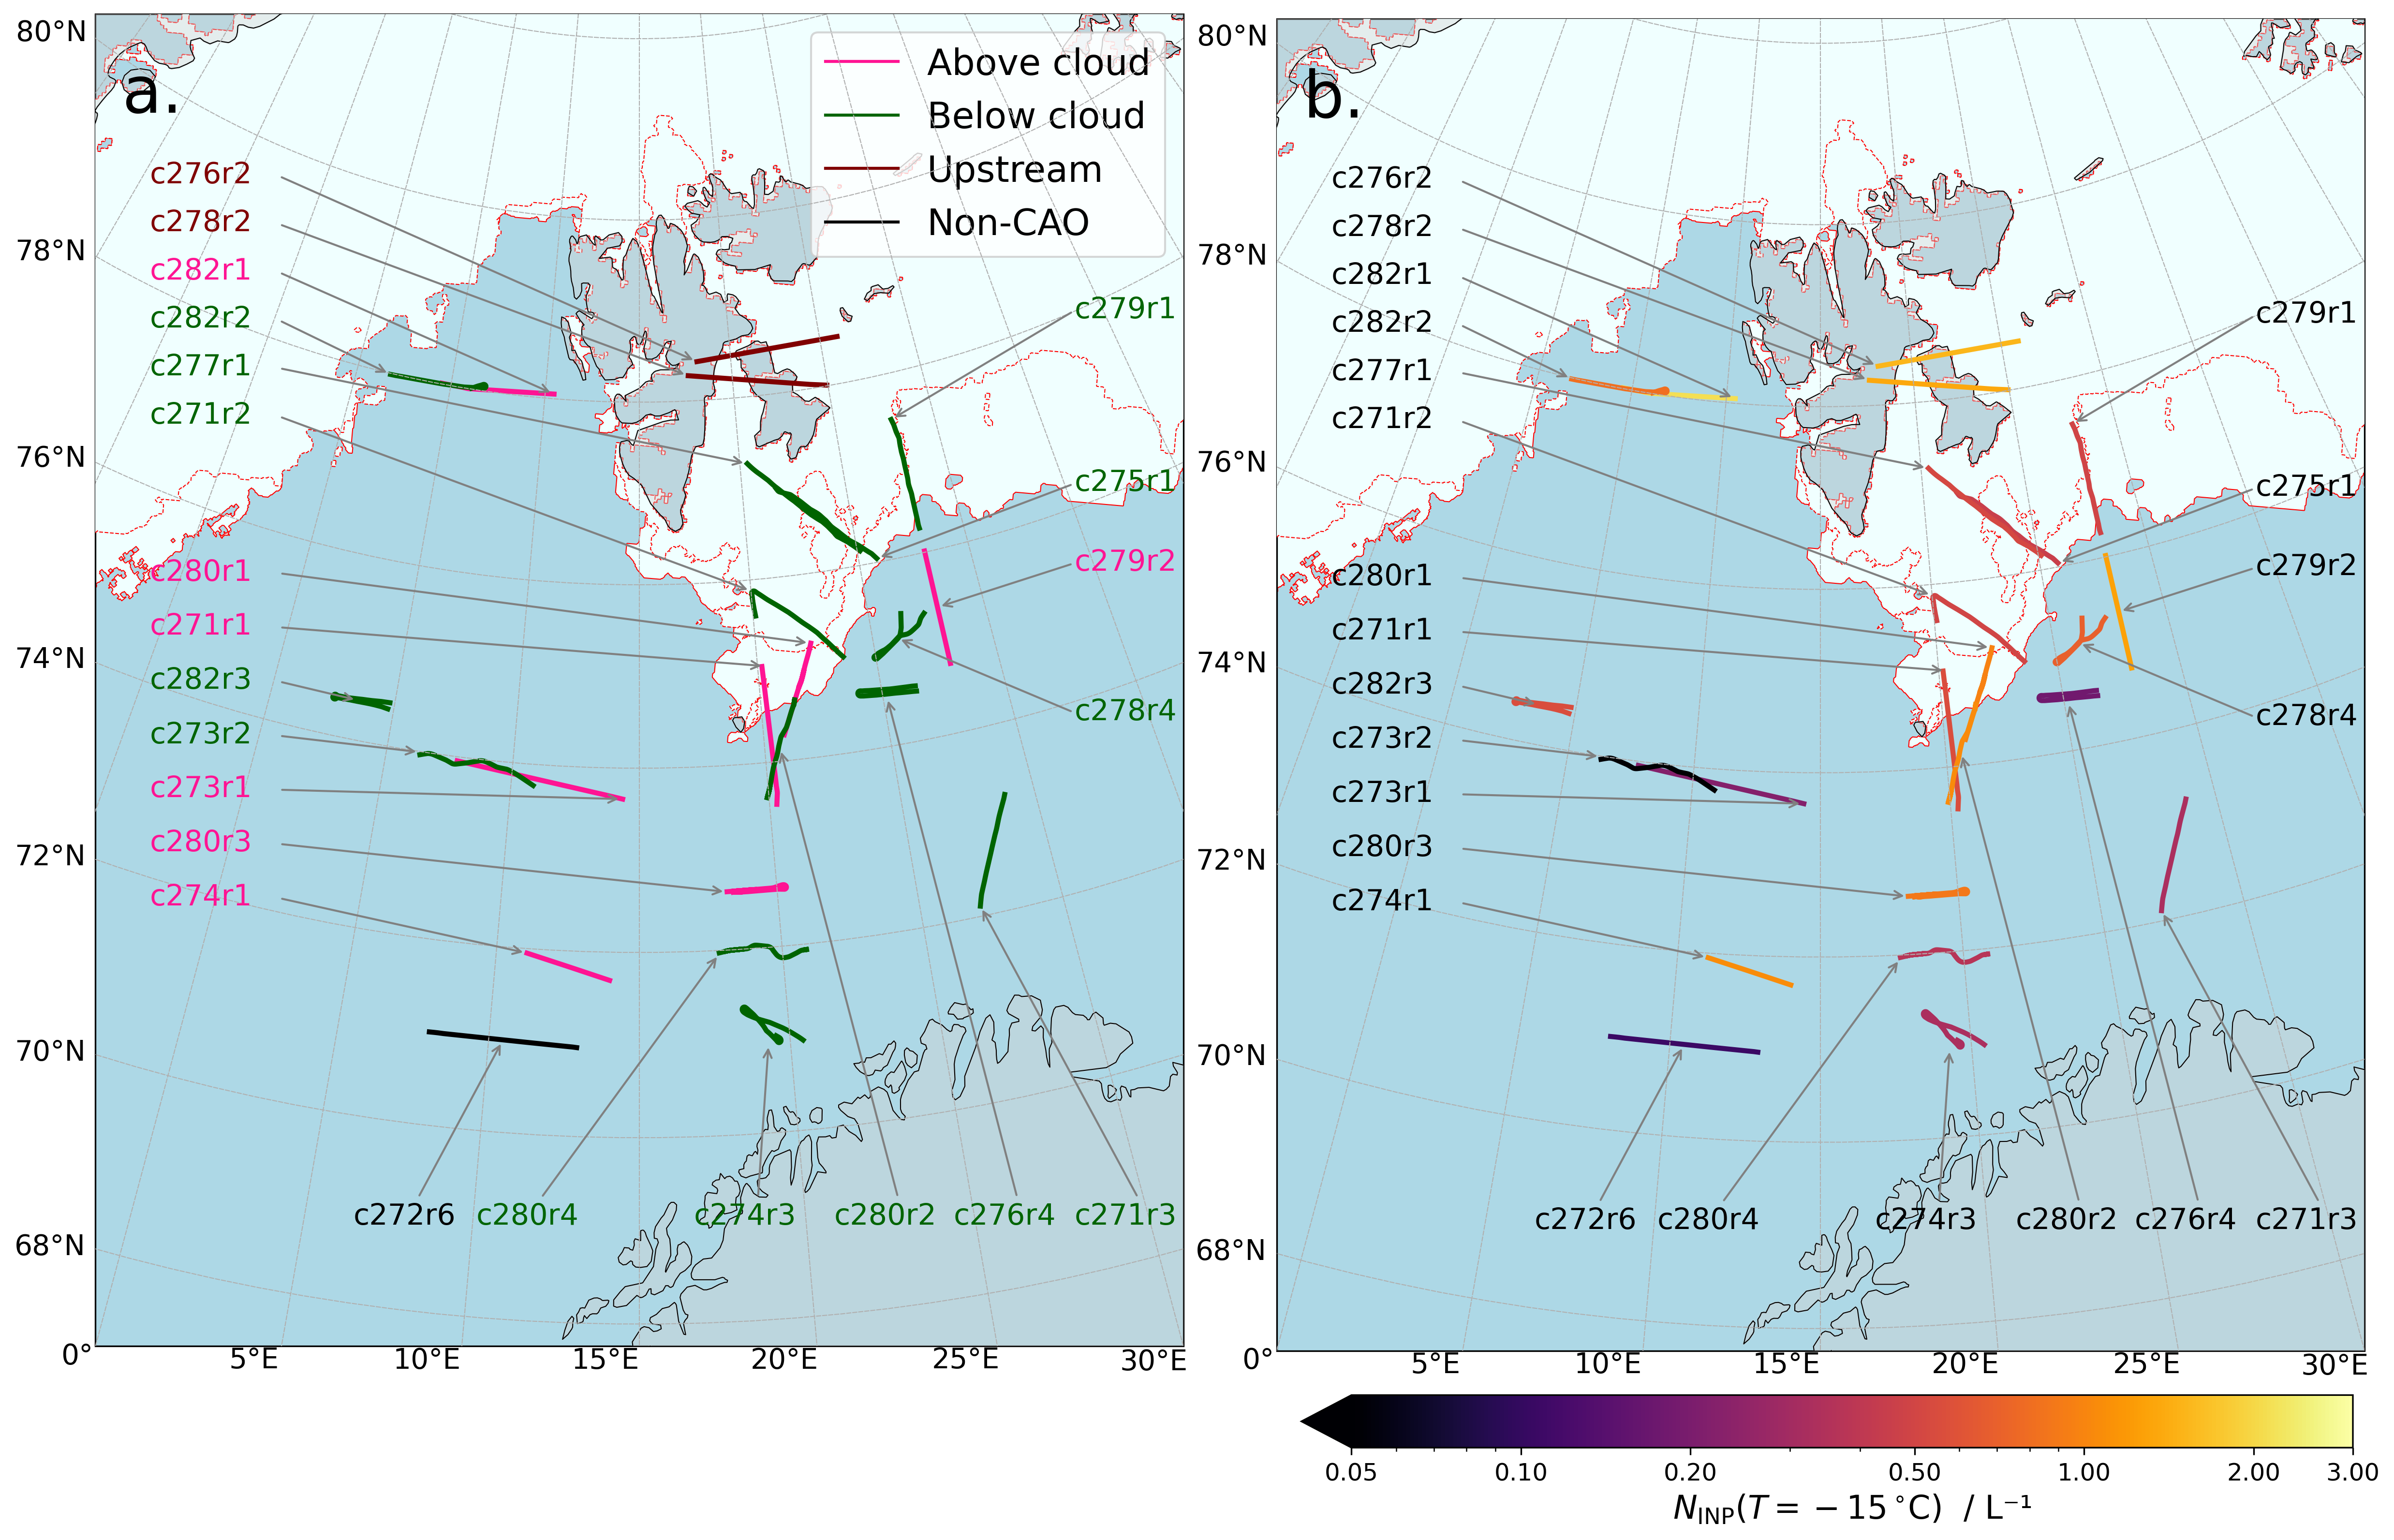

In [30]:
# Create a discretised colormap based on the PuRd
norm = mcolors.LogNorm(0.05,3)
cm = plt.cm.inferno
# Make plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(17,10.5),
                       subplot_kw=dict(projection=NPS),dpi=300)
for ax in (ax1, ax2):
    make_map(ax, PC, NPS, add=True)
# Plot filter tracks and annotate them
filter_info = filter_info.apply(lambda row: plot_filter_legs(ax1, ax2, row,
                                                             INP_concentrations,
                                                             cm, norm), axis=1)
plt.draw()
_ = filter_info.apply(lambda row: add_annotation(row,ax1,True),axis=1)
_ = filter_info.apply(lambda row: add_annotation(row,ax2,False),axis=1)
# "Hidden" plots to create legend
ax1.plot([0,1],[0,1],transform = ccrs.PlateCarree(),color='deeppink',
        label='Above cloud')
ax1.plot([0,1],[0,1],transform = ccrs.PlateCarree(),color='darkgreen',
        label='Below cloud')
ax1.plot([0,1],[0,1],transform = ccrs.PlateCarree(),color='maroon',
        label='Upstream')
ax1.plot([0,1],[0,1],transform = ccrs.PlateCarree(),color='black',
        label='Non-CAO')

ax1.text(-18,79.5,"a.",size=32,transform=PC,zorder=20)
ax2.text(-18,79.5,"b.",size=32,transform=PC,zorder=20)
fig.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
cb = fig.colorbar(sm, ax=ax2, orientation="horizontal", extend='min', pad=0.03, fraction=0.07, shrink=1,
                  ticks=[0.05, 0.1, 0.2, 0.5, 1, 2, 3],
                 format=mpl.ticker.ScalarFormatter())
cb.set_label(r'$N_{\mathrm{INP}}\left(T=-15\,^{\circ}\mathrm{C}\right)$  / L⁻¹', fontsize=16)
cb.ax.tick_params(labelsize=12)

ax1_extents = ax1.get_position().bounds
ax2_extents = ax2.get_position().bounds
ax1.set_position([ax1_extents[0], ax2_extents[1]+0.003, ax2_extents[2], ax2_extents[3]])
plt.draw()
cb_extents = cb.ax.get_position().bounds
axis_x_shift = ax2_extents[0] - cb_extents[0]
ax1.legend(loc='upper right',ncol=1,fontsize=18)

ax2.set_position([ax2_extents[0]-0.02, ax2_extents[1], ax2_extents[2], ax2_extents[3]])
cb.ax.set_position([cb_extents[0]-0.028, cb_extents[1], cb_extents[2], cb_extents[3]])
fig.savefig('./imgs/f02.png',bbox_inches='tight')